# 11.11 学习率调度器
- **目录**
  - 11.11.1 学习率简单示例
  - 11.11.2 学习率调度器简单实现
  - 11.11.3 学习率调度策略
    - 11.11.3.1 单因子调度器
    - 11.11.3.2 多因子调度器
    - 11.11.3.3 余弦调度器
    - 11.11.3.4 预热

到目前为止，我们主要关注如何更新权重向量的优化算法，而不是它们的更新速率。 然而，**调整学习率通常与实际算法同样重要**，有如下几方面需要考虑：

- 首先，学习率的大小很重要。如果它太大，优化就会发散；如果它太小，训练就会需要过长时间，或者我们最终只能得到次优的结果。我们之前看到问题的条件数很重要（有关详细信息，请参见 11.6节 动量法）。直观地说，这是最不敏感与最敏感方向的变化量的比率。

- 其次，衰减速率同样很重要。如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。 11.5 小批量随机梯度下降比较详细地讨论了这一点，在 11.4 随机梯度下降中我们则分析了性能保证。简而言之，我们希望速率衰减，但要比$\mathcal O(t^{-1/2})$慢，这样能成为解决凸问题的不错选择。

- 另一个同样重要的方面是初始化。这既涉及参数最初的设置方式（详情请参阅 4.8节），又关系到它们最初的演变方式。这被戏称为**预热（warmup）**，即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向可能也是毫无意义的。

- 最后，还有许多优化变体可以执行周期性学习率调整，如何通过对整个路径参数求平均值来获得更好的解。

鉴于管理学习率需要很多细节，因此大多数深度学习框架都有自动应对这个问题的工具。 在本章中，我们将梳理不同的调度策略对准确性的影响，并展示如何通过**学习率调度器（learning rate scheduler）** 来有效管理。

- **要点：**
  - **学习率的大小重要性**：
     - 过大的学习率可能导致优化发散。
     - 过小的学习率可能导致训练过程过长或仅获得次优解。
     - 学习率的选择与问题的条件数有关。
  - **衰减速率的重要性**：
     - 持续过高的学习率可能导致在最小值附近弹跳，无法达到最优。
     - 理想状况是一个缓慢衰减的学习率。
  - **初始化的重要性**：
     - 包括参数的初始设置以及它们最初的演变方式。
     - 过于迅速的**初始步进**可能不利，特别是初始参数设置是随机的。
  - **周期性学习率调整和路径平均**：
     - 一些优化变体可以执行周期性的学习率调整。
     - 可能通过路径参数的平均值获得更好的解。
  - **预热（warmup）的概念**：
     - 关于最初开始向解决方案迈进的速度。
  - **学习率调度器的自动管理工具**：
     - 大多数深度学习框架提供了处理学习率调整的工具。
     - 在训练过程中梳理不同调度策略的影响，并展示如何有效管理。

## 11.11.1 学习率简单示例
- 选择一个稍微现代化的LeNet版本（激活函数使用relu而不是sigmoid，池化层使用最大池化层而不是平均池化层），并应用于Fashion-MNIST数据集。
- 通过**混合网络**（CNN+MLP）以提高性能。 
- 由于大多数代码都是标准的，此处只介绍基础知识，而不做进一步的详细讨论。

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

- 让我们来看看如果使用默认设置，调用此算法会发生什么。
- 例如设学习率为$0.3$并训练$30$次迭代。
- 留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。
- 两条曲线之间的间隙表示过拟合。


train loss 0.161, train acc 0.939, test acc 0.885


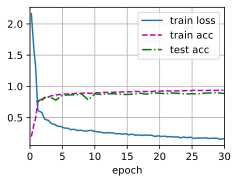

In [2]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 11.11.2 学习率调度器简单实现
- 可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。 
  - 例如，以动态的方式来响应优化的进展情况。


In [3]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


- 通常应该定义一个调度器。
- 当调用更新次数时，它将返回学习率的适当值。
- 下面定义一个简单的方法，将学习率设置为$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

- 在一系列值上绘制它的行为。


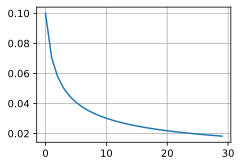

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

- 现在来看看这对在Fashion-MNIST数据集上的训练有何影响。
- 此处只是提供调度器作为训练算法的额外参数。


train loss 0.279, train acc 0.898, test acc 0.870


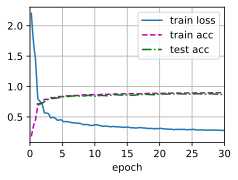

In [6]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

- 这比以前好一些：曲线比以前更加平滑，并且过拟合更小了。
- 遗憾的是，关于为什么在理论上某些策略会导致较轻的过拟合，有一些观点认为，**较小的步长将导致参数更接近零**，因此更简单。
- 但是，这并不能完全解释这种现象，并没有真正地提前停止，而只是**轻柔地降低了学习率**。

## 11.11.3 学习率调度策略
- 虽然不可能涵盖所有类型的学习率调度器，但我们会尝试在下面简要概述常用的策略：**多项式衰减**和**分段常数表**。
- **余弦学习率调度**在实践中的一些问题上运行效果很好。 
- 在某些问题上，最好在使用较高的学习率之前**预热优化器**。

### 11.11.3.1 单因子调度器

- 多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$，其中$\alpha \in (0, 1)$。
- 为了防止学习率衰减超出合理的下限，更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。

### 11.11.3.1 单因子调度器

- 多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$，其中$\alpha \in (0, 1)$。
- 为了防止学习率衰减超出合理的下限，更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。

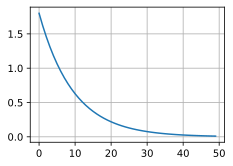

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

- 接下来将使用内置的调度器，但在这里仅解释它们的功能。

### 11.11.3.2 多因子调度器

- 训练深度网络的常见策略之一是**保持分段稳定的学习率，并且每隔一段时间就一定程度学习率降低**。
- 具体地说，给定一组降低学习率的时间，例如$s = \{5, 10, 20\}$每当$t \in s$时降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。
- 假设每步中的值减半，可按如下方式实现这一点。

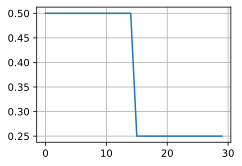

In [8]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

In [7]:
#lr_scheduler.MultiStepLR?

- 这种**分段恒定**学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个**驻点**。
- 此时才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。
- 下面的例子展示了如何使用这种方法产生更好的解决方案。


train loss 0.195, train acc 0.926, test acc 0.892


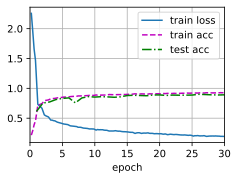

In [9]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 11.11.3.3 余弦调度器

- 余弦调度器所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。
- 这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在$t \in [0, T]$之间。
$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right) \tag{11.11.1}$$
  - 这里$\eta_0$是初始学习率，$\eta_T$是当$T$时的目标学习率。
  - 此外，对于$t > T$，我们只需将值固定到$\eta_T$而不再增加它。
- 在下面的示例中，设置了最大更新步数$T = 20$。


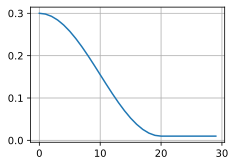

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

- 在计算机视觉中，这个调度可以引出改进的结果。
- 但请注意，如下所示，这种改进并不能保证成立。


train loss 0.171, train acc 0.936, test acc 0.904


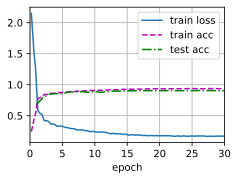

In [11]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 11.11.3.4 预热

- 在某些情况下，初始化参数不足以得到良好的解。
- 这对于某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。
  - 对此，一方面，我们可以选择一个足够小的学习率，从而防止一开始发散，然而这样进展太缓慢。
  - 另一方面，较高的学习率最初就会导致发散。
- 解决这种困境的一个相当简单的解决方法是使用**预热期**，在此期间学习率将**增加至初始最大值，然后冷却直到优化过程结束**。
- 为了简单起见，通常使用**线性递增**。
- 这引出了如下表所示的时间表。


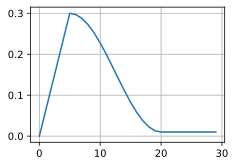

In [12]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好。


train loss 0.180, train acc 0.934, test acc 0.904


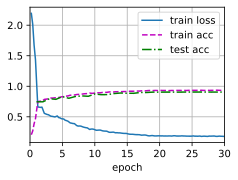

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

- 预热可以应用于任何调度器，而不仅仅是余弦。
- 这在直觉上是有道理的：在网络中那些**一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散**。

## 小结

* 在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。
* 在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收敛到一个适当的解，也只有这样才能通过降低学习率来减小参数的固有方差。
* 余弦调度器在某些计算机视觉问题中很受欢迎。
* 优化之前的预热期可以防止发散。
* 优化在深度学习中有多种用途。对于同样的训练误差而言，选择不同的优化算法和学习率调度，除了最大限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量。